In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.inspection import partial_dependence

# Set font before plotting
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# Data Preprocessing

In [2]:
# Read the CSV
df = pd.read_csv('C:/Users/User/Downloads/Kyushu Datasheets/data_with_press_and_weather.csv', low_memory=False)

# Drop rows with excessive missing values
missing_count = df.isnull().sum().sum()
if missing_count > 0:
    threshold = df.shape[1] // 2
    df = df.dropna(thresh=threshold + 1)
    print(f"Rows with more than half NaN dropped. Remaining rows: {len(df)}")
else:
    print("No missing values found.")

Rows with more than half NaN dropped. Remaining rows: 2811


In [3]:
# Clean and filter '강번'
df['강번'] = pd.to_numeric(df['강번'], errors='coerce')
df = df.dropna(subset=['강번'])
df = df[df['강번'].between(9000, 500000000)]

df.to_csv('For_my_use_1.csv', index=False)

In [4]:
measured = [
    '2024-01-04', '2024-01-11', '2024-01-30', '2024-02-09', '2024-02-16', '2024-03-06', '2024-03-08', '2024-03-11', 
    '2024-03-22', '2024-04-01', '2024-04-17', '2024-04-19', '2024-04-24', '2024-05-02', '2024-05-09', '2024-05-22', 
    '2024-05-31', '2024-06-13', '2024-07-04', '2024-07-31', '2024-08-28', '2024-10-01', '2024-10-16', '2024-10-28', 
    '2024-11-15', '2024-11-29', '2024-12-06', '2024-12-20'
           ]

In [5]:
# Make sure the date column is in datetime format
df['날짜'] = pd.to_datetime(df['날짜'], errors='coerce')
measured_dt = pd.to_datetime(measured)

# Find first index of each measured date
first_indices = {}
for date in measured_dt:
    match = df[df['날짜'] == date]
    if not match.empty:
        first_indices[str(date.date())] = match.index[0]
    else:
        first_indices[str(date.date())] = None  # or -1 if you prefer

# Display result
print("First index for each measured date:")
for k, v in first_indices.items():
    print(f"{k}: {v}")

print('test')

First index for each measured date:
2024-01-04: 0
2024-01-11: 67
2024-01-30: 256
2024-02-09: 344
2024-02-16: 416
2024-03-06: None
2024-03-08: None
2024-03-11: 513
2024-03-22: 610
2024-04-01: 696
2024-04-17: 856
2024-04-19: 872
2024-04-24: 920
2024-05-02: 977
2024-05-09: 1033
2024-05-22: 1162
2024-05-31: 1231
2024-06-13: 1333
2024-07-04: 1480
2024-07-31: 1654
2024-08-28: None
2024-10-01: 2136
2024-10-16: 2271
2024-10-28: 2377
2024-11-15: 2521
2024-11-29: 2665
2024-12-06: 2735
2024-12-20: 2863
test


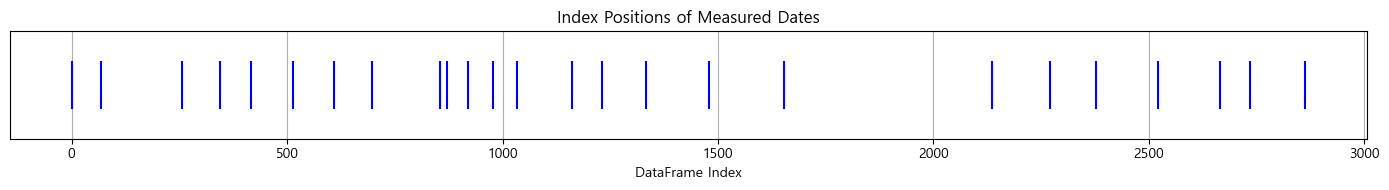

In [6]:
# Assuming 'first_indices' was built as in previous steps
# Filter out missing values
filtered_dates = [date for date in measured if first_indices[date] is not None]
filtered_indices = [first_indices[date] for date in filtered_dates]

# Plot as vertical event lines
plt.figure(figsize=(14, 2))  # wide and short
plt.eventplot(filtered_indices, orientation='horizontal', colors='blue')

plt.title("Index Positions of Measured Dates")
plt.xlabel("DataFrame Index")
plt.yticks([])  # remove y-axis ticks
plt.grid(axis='x')
plt.tight_layout()
plt.show()

In [7]:
chin_variables = [col for col in df.columns if '친' in col and '친단' not in col]
df['chin_total'] = df[chin_variables].sum(axis=1)

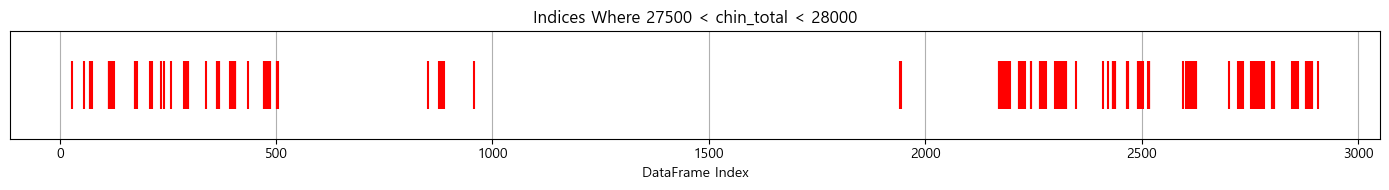

In [8]:
# --- Find indices where chin_total is within range ---
chin_range_indices = df[(df['chin_total'] > 27500) & (df['chin_total'] < 28000)].index.tolist()

# --- Plot as horizontal event markers ---
plt.figure(figsize=(14, 2))  # wide and short
plt.eventplot(chin_range_indices, orientation='horizontal', colors='red')

plt.title("Indices Where 27500 < chin_total < 28000")
plt.xlabel("DataFrame Index")
plt.yticks([])  # Hide y-axis
plt.grid(axis='x')
plt.tight_layout()
plt.show()

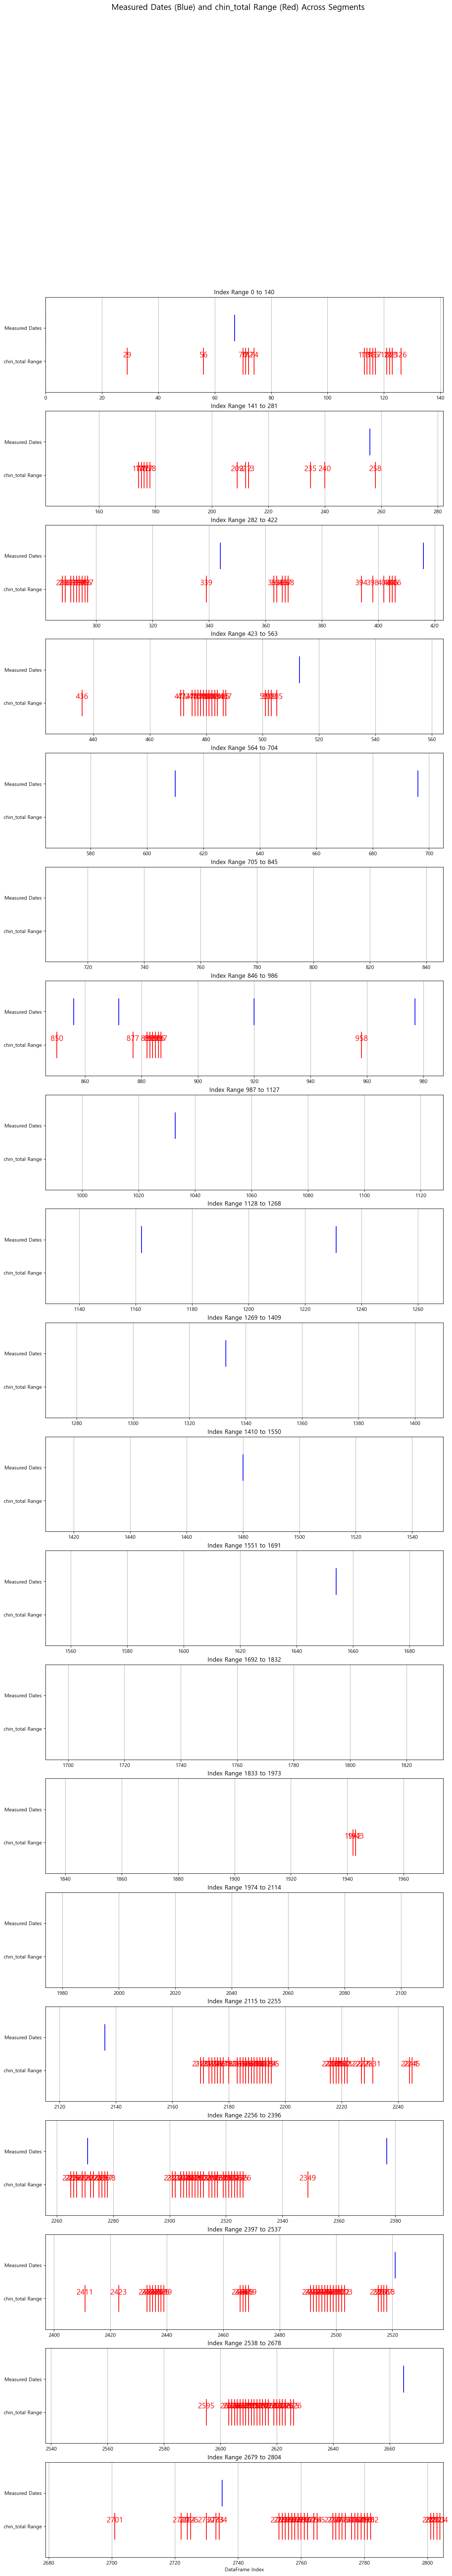

In [9]:
import matplotlib.pyplot as plt
import math

# Total index range
total_len = len(df)
segment_size = math.ceil(total_len / 20)

# Prepare figure
fig, axes = plt.subplots(20, 1, figsize=(14,80), sharey=True)

for i in range(20):
    start = i * segment_size
    end = min((i + 1) * segment_size, total_len)

    # Filter indices for this segment
    measured_segment = [idx for idx in filtered_indices if start <= idx < end]
    chin_segment = [idx for idx in chin_range_indices if start <= idx < end]

    # Plot on subplot
    axes[i].eventplot([measured_segment, chin_segment],
                      orientation='horizontal',
                      lineoffsets=[1, 0],
                      linelengths=0.8,
                      colors=['blue', 'red'])

    # Annotate red (chin_segment) points
    for x in chin_segment:
        axes[i].annotate(str(x),
                         xy=(x, 0),             # position on the red line
                         xytext=(0, 8),         # offset upward
                         textcoords='offset points',
                         ha='center',
                         fontsize=15,
                         color='red')

    axes[i].set_xlim(start, end)
    axes[i].set_yticks([0, 1])
    axes[i].set_yticklabels(['chin_total Range', 'Measured Dates'])
    axes[i].set_title(f'Index Range {start} to {end - 1}')
    axes[i].grid(axis='x')

# Final layout
fig.suptitle("Measured Dates (Blue) and chin_total Range (Red) Across Segments", fontsize=16)
plt.xlabel("DataFrame Index")
plt.show()


In [10]:
# Compute the average
average_chin_total = df['chin_total'].mean()

print(f"Average chin_total: {average_chin_total:.2f}")

average_power_total = df['사용전력량'].mean()

print(f"Average 사용전력량: {average_power_total:.2f}")

average_additional_power_total = df['유효전력량_주장'].mean()

print(f"Average 유효전력량_주장: {average_additional_power_total:.2f}")

Average chin_total: 28430.72
Average 사용전력량: 18044.59
Average 유효전력량_주장: 5956.18


In [11]:
df.iloc[816, df.columns.get_loc('강번')]

np.float64(2404154.0)

In [12]:
print("Number of rows in df:", len(df))

Number of rows in df: 2805


# Chin Plots

In [13]:
def plot_chin_total_by_position(df, start_pos, end_pos, exclude=None, marker_between=None, mean_line=None):
    """
    Plots chin_total vs row index for a given range, optionally excluding positions.
    Adds vertical marker line (between two row positions) and horizontal mean line.
    
    Parameters:
        marker_between: tuple of two positions (e.g., (2727, 2728)) to draw vertical line between.
        mean_line: float, y-value to draw horizontal line (e.g., 28545.08)
    """
    if 'chin_total' not in df.columns:
        chin_variables = [col for col in df.columns if '친' in col and '친단' not in col]
        df['chin_total'] = df[chin_variables].sum(axis=1)

    exclude = exclude or []

    # Prepare data
    x_indices = []
    y_chin = []
    for i in range(start_pos, end_pos + 1):
        if i in exclude:
            continue
        idx_label = df.index[i]
        chin_val = df.iloc[i]['chin_total']
        x_indices.append(idx_label)
        y_chin.append(chin_val)

    # Plot chin_total
    plt.figure(figsize=(10, 5))
    plt.plot(x_indices, y_chin, marker='o', linestyle='-', label='chin_total')

    # Vertical line between two indices
    if marker_between:
        i1, i2 = marker_between
        if 0 <= i1 < len(df.index) and 0 <= i2 < len(df.index):
            idx1 = df.index[i1]
            idx2 = df.index[i2]
            midpoint = (idx1 + idx2) / 2
            plt.axvline(x=midpoint, color='red', linestyle='--', linewidth=2, label='Repair point')

    # Horizontal mean line
    if mean_line is not None:
        plt.axhline(y=mean_line, color='gray', linestyle='--', linewidth=2, label=f'Mean = {mean_line:.2f}')

    # Final plot config
    plt.title(f"chin_total from dates 11/26 - 12/01")
    plt.xlabel("Index")
    plt.ylabel("chin_total")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

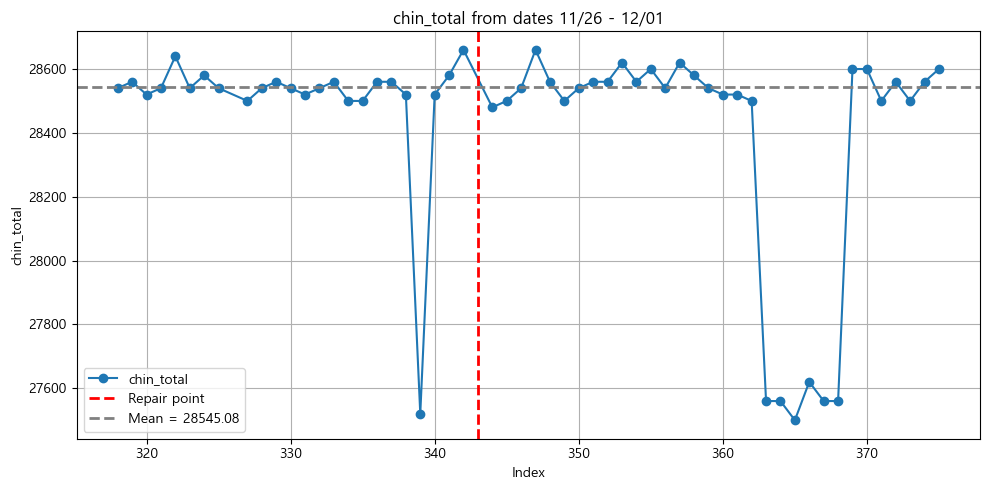

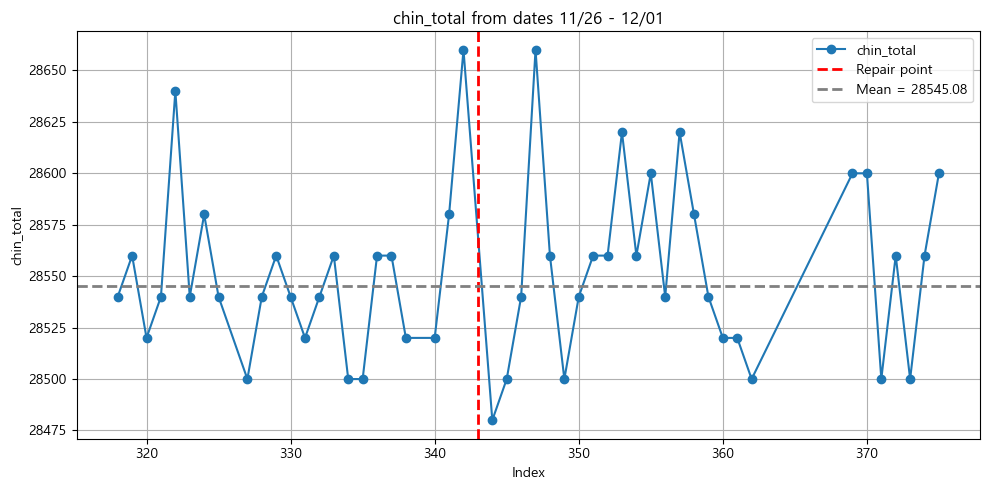

In [14]:
plot_chin_total_by_position(df, 304, 359, exclude=[], marker_between = (327, 328), mean_line = 28545.08)
plot_chin_total_by_position(df, 304, 359, exclude= [324] + list(range(347, 353)), marker_between = (327, 328), mean_line = 28545.08)

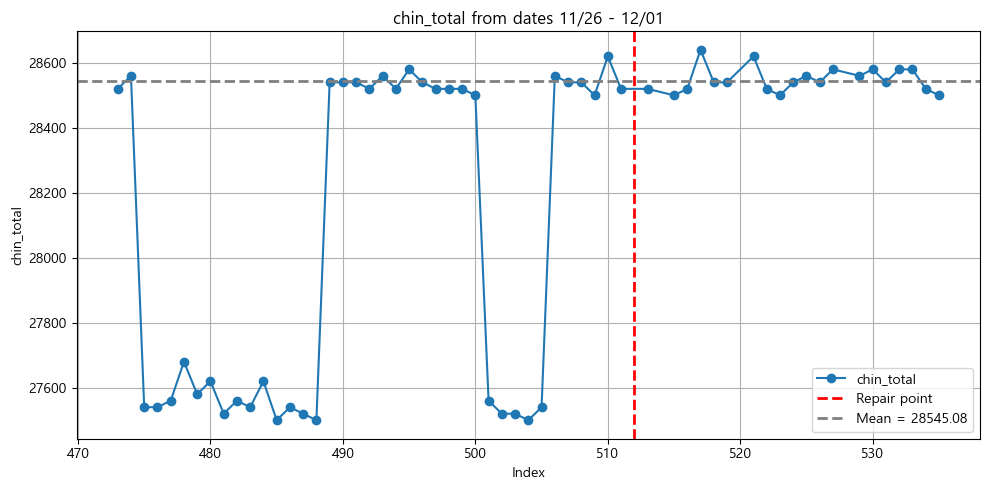

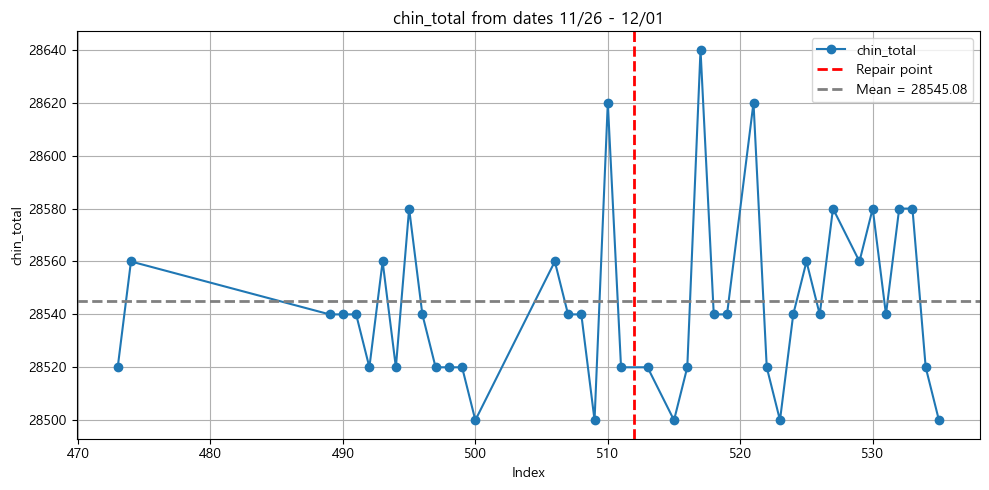

In [15]:
# 2/23 - 3/13
plot_chin_total_by_position(df, 451, 509, exclude= [], marker_between = (489, 490), mean_line = 28545.08)
plot_chin_total_by_position(df, 451, 509, exclude= list(range(453, 467)) + list(range(479, 484)), marker_between = (489, 490), mean_line = 28545.08)

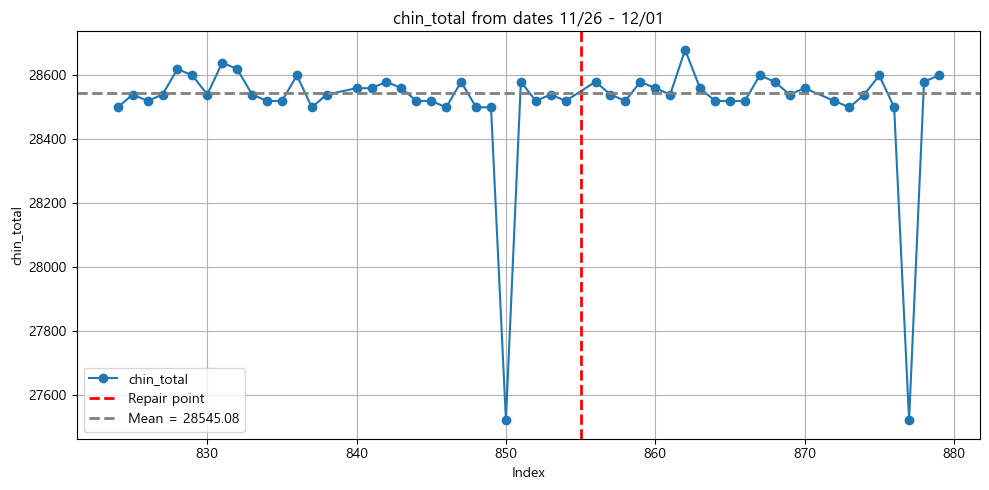

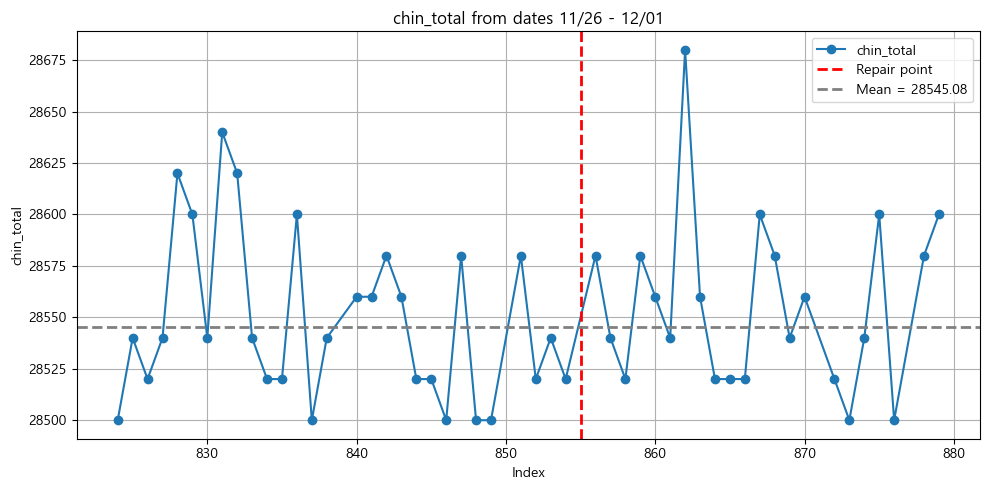

In [16]:
plot_chin_total_by_position(df, 786, 838, exclude=[], marker_between = (815, 816), mean_line = 28545.08)
plot_chin_total_by_position(df, 786, 838, exclude=[811, 836], marker_between = (815, 816), mean_line = 28545.08)

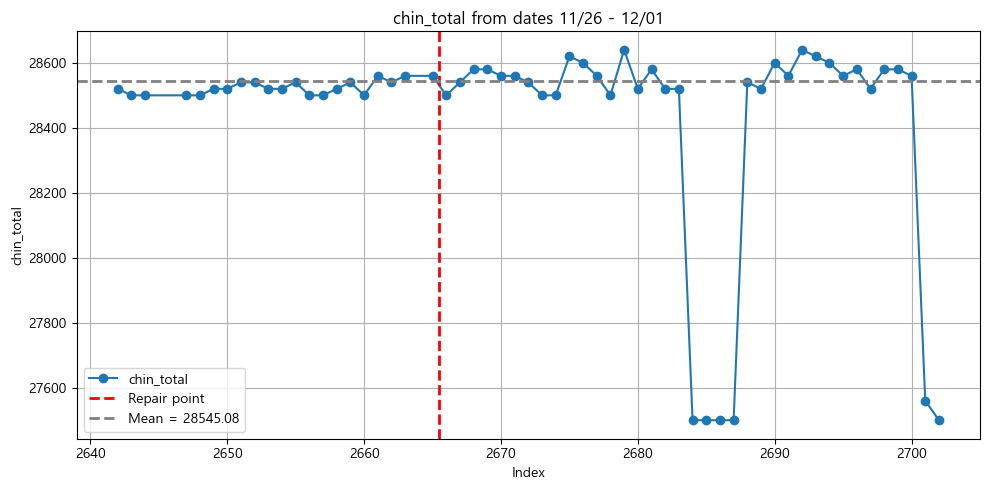

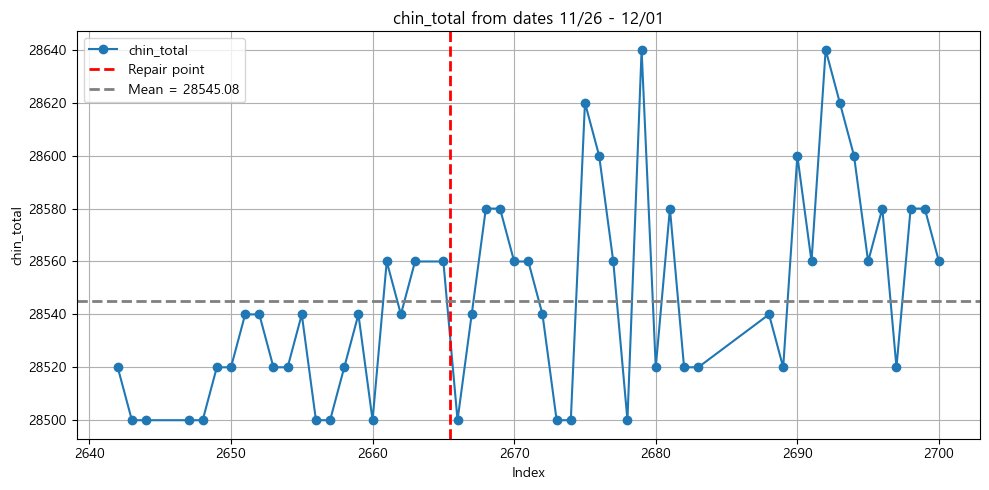

In [17]:
plot_chin_total_by_position(df, 2518, 2575, exclude=[], marker_between = (2538, 2539), mean_line = 28545.08)
plot_chin_total_by_position(df, 2518, 2575, exclude=[2557, 2558, 2559, 2560, 2574, 2575], marker_between = (2538, 2539), mean_line = 28545.08)

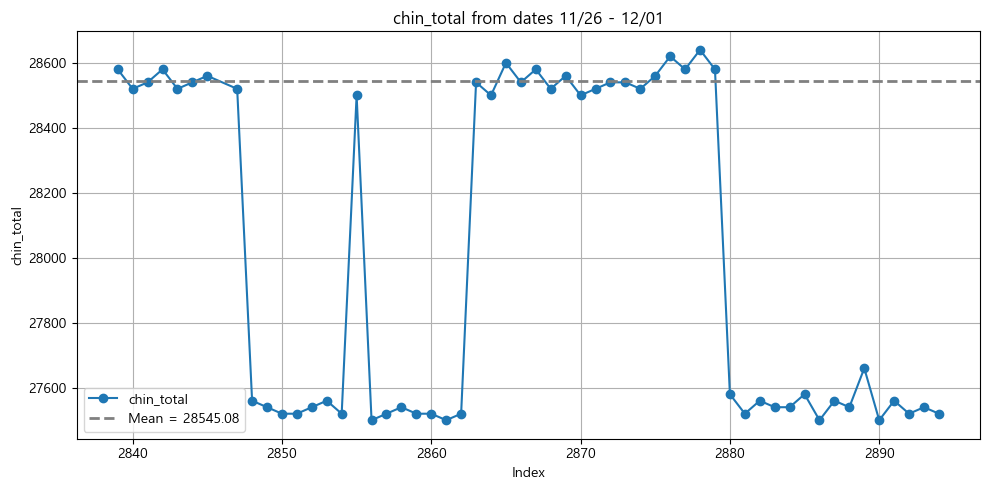

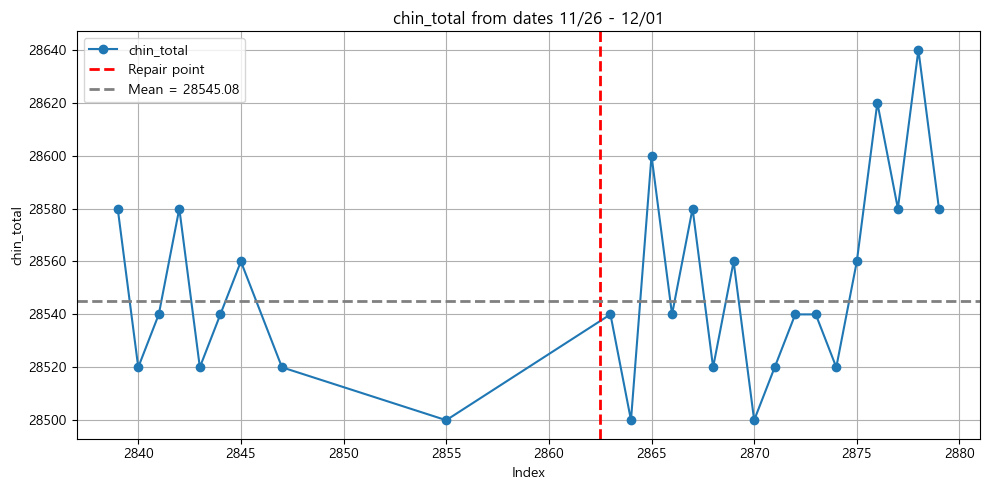

In [18]:
plot_chin_total_by_position(df, 2705, 2759, exclude = [], mean_line = 28545.08)
plot_chin_total_by_position(df, 2705, 2759, list(range(2713, 2720)) + list(range(2721, 2728)) + list(range(2745, 2760)), marker_between = (2727, 2728), mean_line = 28545.08)

# Power Consumption

In [19]:
def plot_column_by_position(df, column, start_pos, end_pos, exclude=None, marker_between=None, mean_line=None):
    """
    Plots the specified column vs index position, with options:
    - Exclude specific row positions
    - Add a vertical marker between two positions
    - Add a horizontal line for the mean value
    
    Parameters:
        column (str): Name of the column to plot (e.g., '사용전력량')
        marker_between (tuple): (i1, i2) to draw vertical line between
        mean_line (float): Value to draw horizontal mean line
    """
    exclude = exclude or []

    # Prepare data
    x_indices = []
    y_values = []
    for i in range(start_pos, end_pos + 1):
        if i in exclude:
            continue
        idx_label = df.index[i]
        y_val = df.iloc[i][column]
        x_indices.append(idx_label)
        y_values.append(y_val)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(x_indices, y_values, marker='o', linestyle='-', label=column)

    # Vertical line between two positions
    if marker_between:
        i1, i2 = marker_between
        if 0 <= i1 < len(df.index) and 0 <= i2 < len(df.index):
            idx1 = df.index[i1]
            idx2 = df.index[i2]
            midpoint = (idx1 + idx2) / 2
            plt.axvline(x=midpoint, color='red', linestyle='--', linewidth=2, label=f'Marker between {i1}-{i2}')

    # Horizontal mean line
    if mean_line is not None:
        plt.axhline(y=mean_line, color='gray', linestyle='--', linewidth=2, label=f'Mean = {mean_line:.2f}')

    # Final plot config
    plt.title(f"{column} from row {start_pos} to {end_pos}")
    plt.xlabel("Index")
    plt.ylabel(column)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

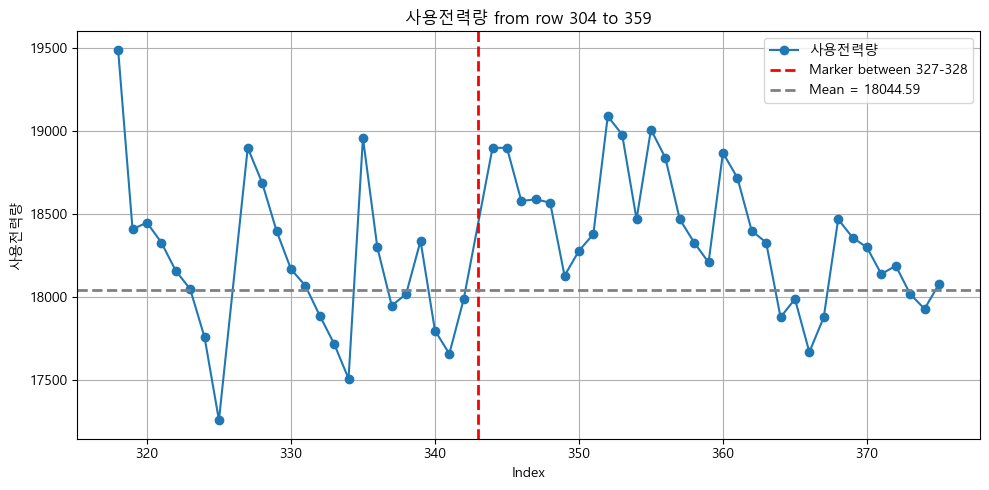

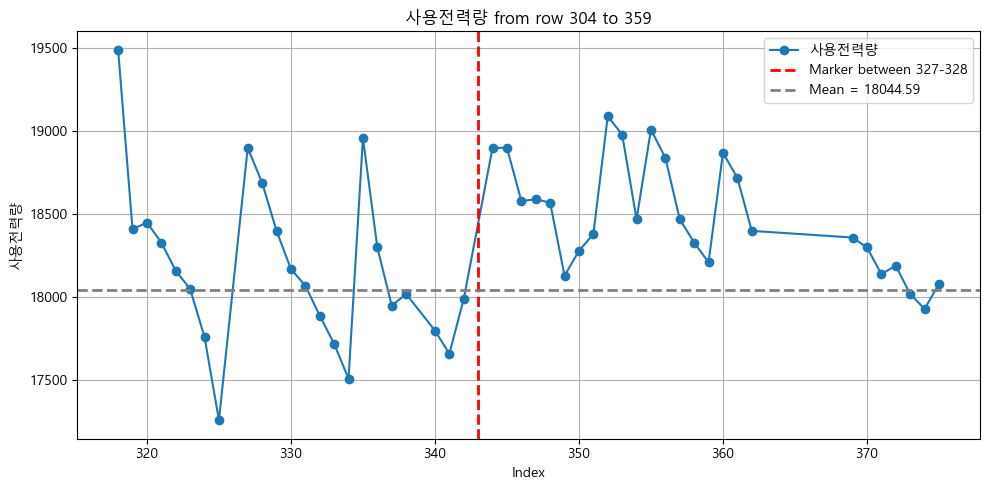

In [20]:
# 2/6 - 2/11

plot_column_by_position(df, '사용전력량', 304, 359, exclude= [], marker_between = (327, 328), mean_line = 18044.59)
plot_column_by_position(df, '사용전력량', 304, 359, exclude= [324] + list(range(347, 353)), marker_between = (327, 328), mean_line = 18044.59)

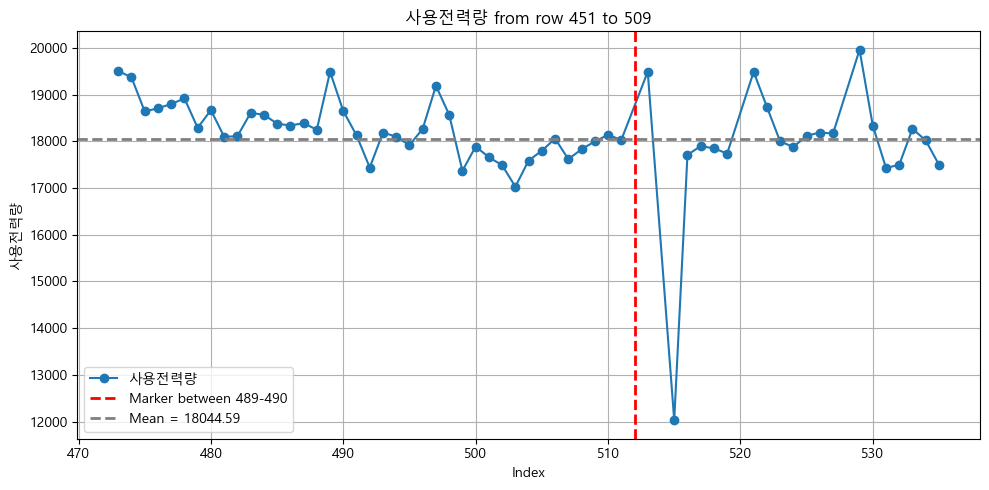

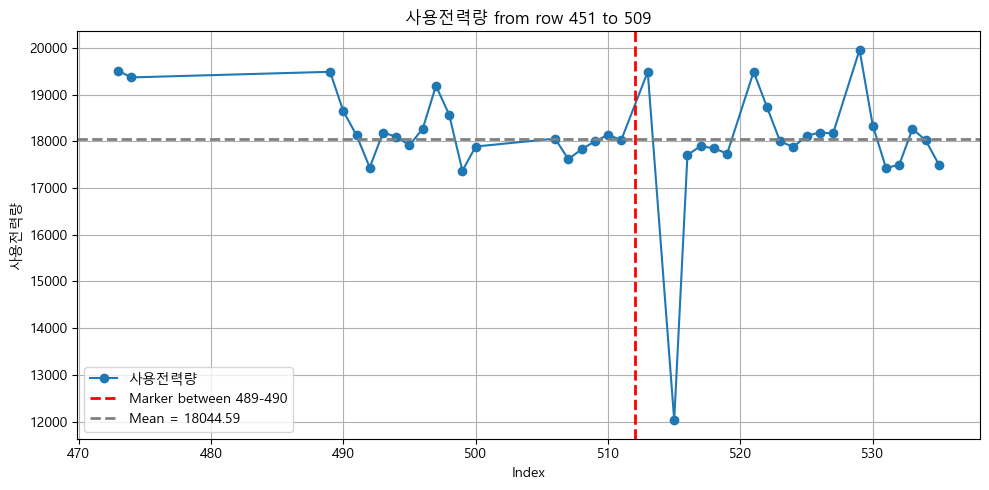

In [21]:
# 2/23 - 3/13
plot_column_by_position(df, '사용전력량', 451, 509, exclude= [], marker_between = (489, 490), mean_line = 18044.59)
plot_column_by_position(df, '사용전력량', 451, 509, exclude= list(range(453, 467)) + list(range(479, 484)), marker_between = (489, 490), mean_line = 18044.59)

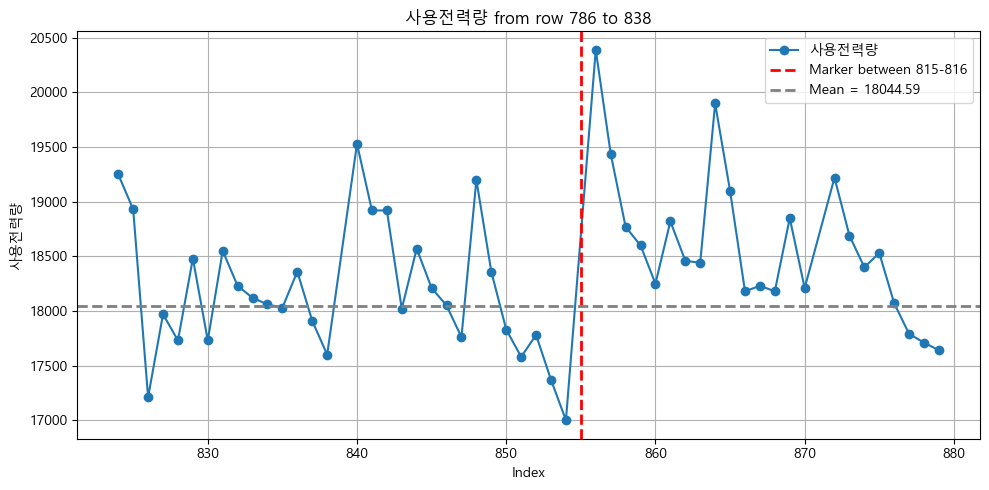

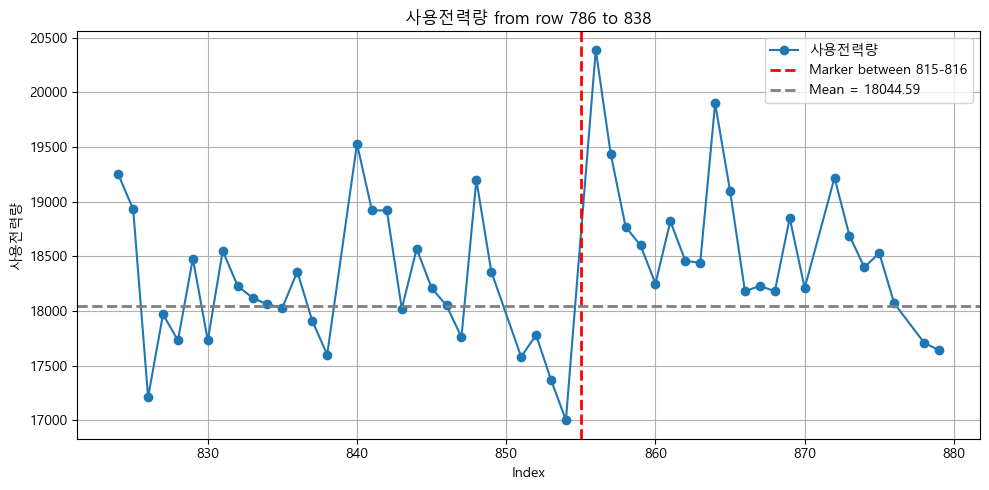

In [22]:
# 4/14 - 4/19

plot_column_by_position(df, '사용전력량', 786, 838, exclude=[], marker_between = (815, 816), mean_line = 18044.59)
plot_column_by_position(df, '사용전력량', 786, 838, exclude=[811, 836], marker_between = (815, 816), mean_line = 18044.59)

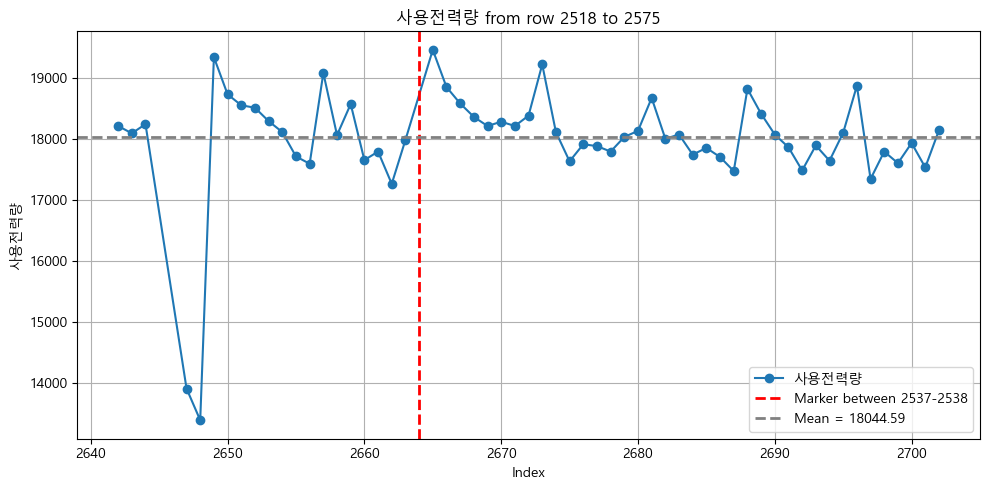

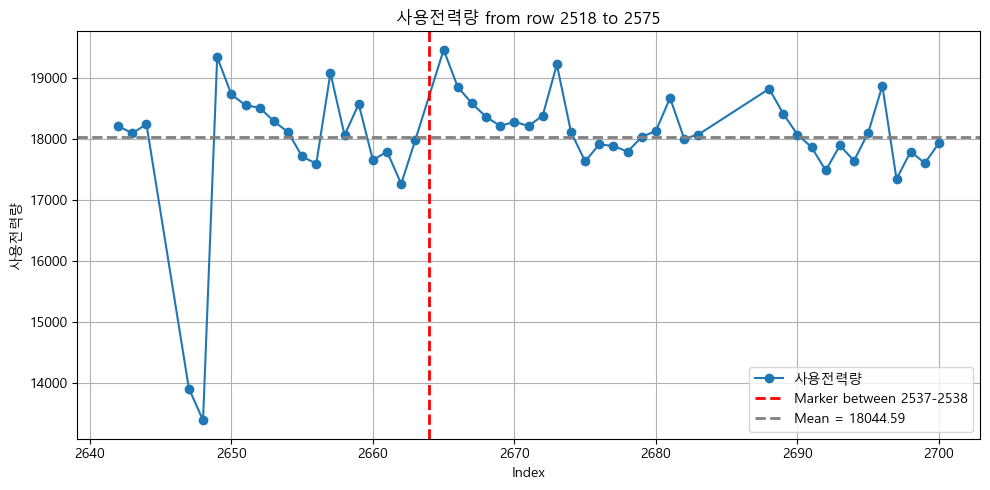

In [23]:
# 11/26 - 12/01

plot_column_by_position(df, '사용전력량', 2518, 2575, exclude=[], marker_between = (2537, 2538), mean_line = 18044.59)
plot_column_by_position(df, '사용전력량', 2518, 2575, exclude=[2557, 2558, 2559, 2560, 2574, 2575], marker_between = (2537, 2538), mean_line = 18044.59)

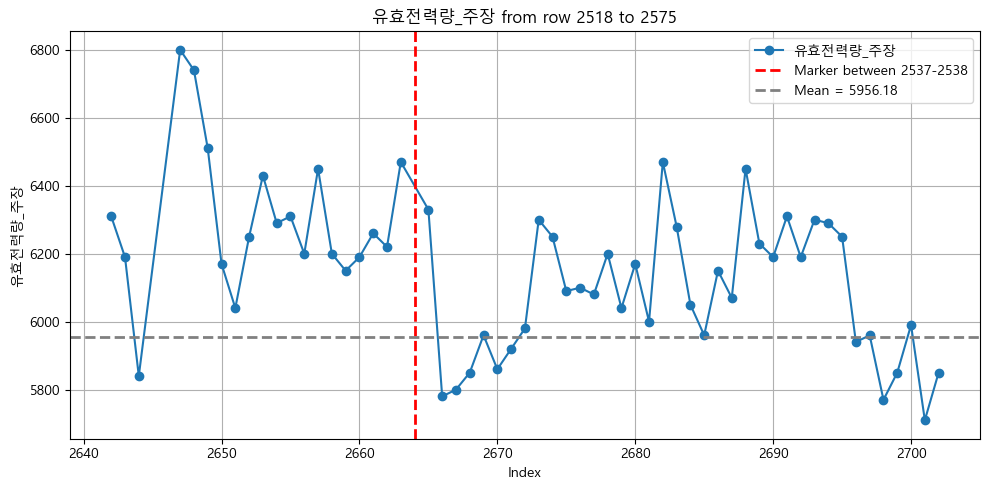

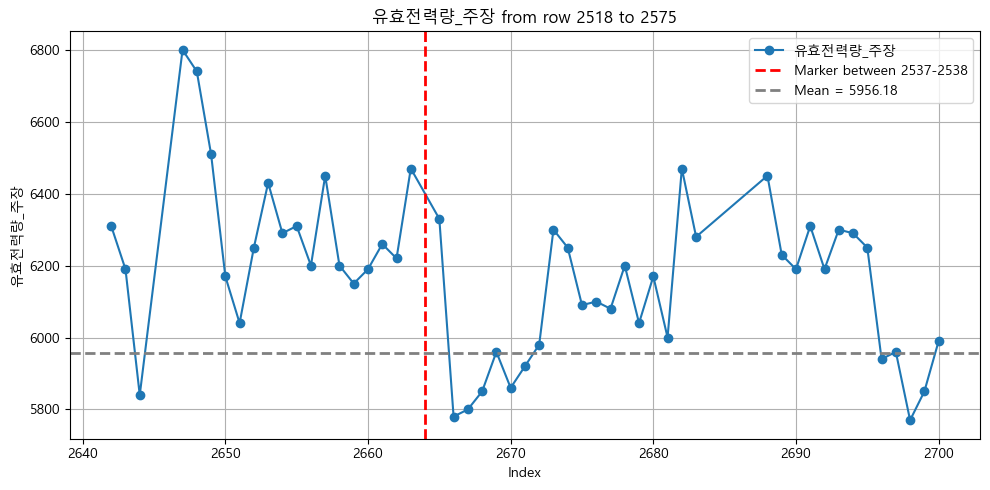

In [24]:
# 11/26 - 12/01

plot_column_by_position(df, '유효전력량_주장', 2518, 2575, exclude=[], marker_between = (2537, 2538), mean_line = 5956.18)
plot_column_by_position(df, '유효전력량_주장', 2518, 2575, exclude=[2557, 2558, 2559, 2560, 2574, 2575], marker_between = (2537, 2538), mean_line = 5956.18)

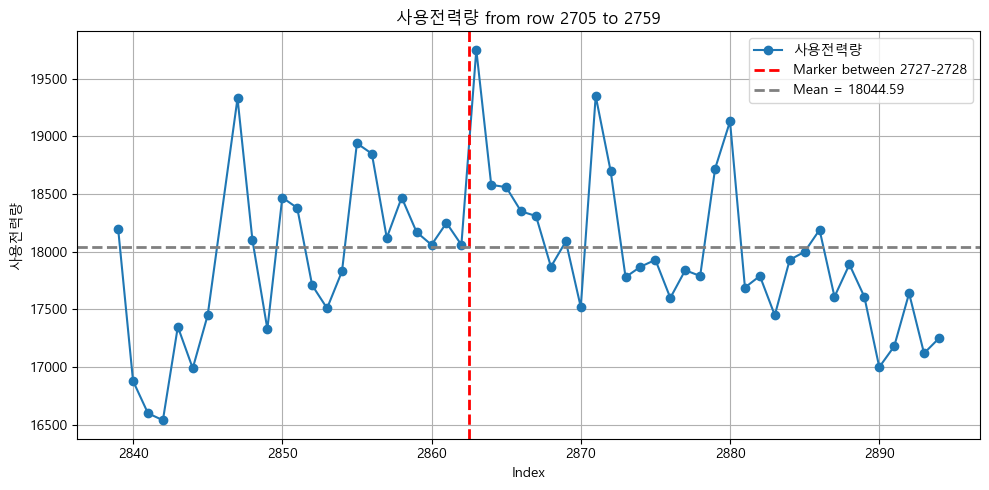

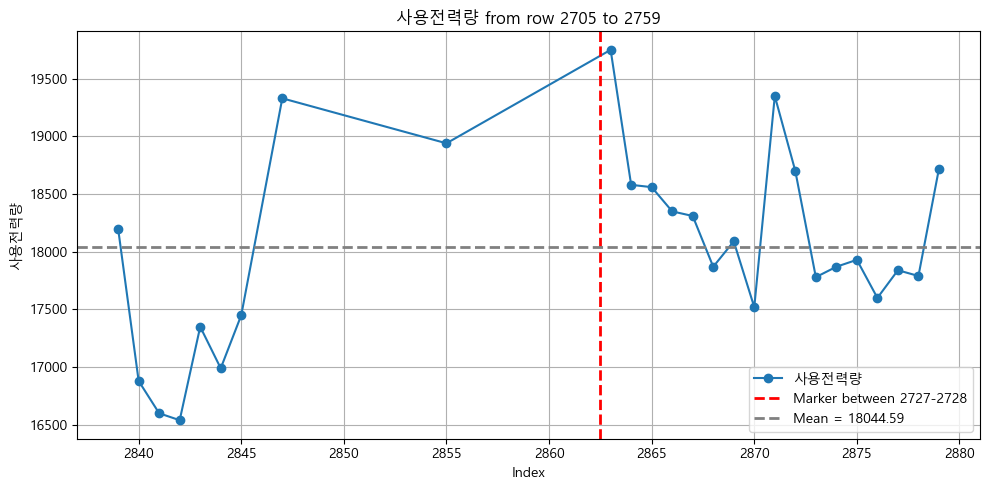

In [25]:
# 12/17 - 12/22

plot_column_by_position(df, '사용전력량', 2705, 2759, exclude = [],marker_between = (2727, 2728), mean_line = 18044.59)
plot_column_by_position(df, '사용전력량', 2705, 2759, list(range(2713, 2720)) + list(range(2721, 2728)) + list(range(2745, 2760)), marker_between = (2727, 2728), mean_line = 18044.59)

# Try

In [26]:
def plot_column_by_date(df, column, start_date, end_date, exclude=None, marker_between=None, mean_line=None):
    """
    Selects data between start_date and end_date (from '날짜'), but plots using index as x-axis.
    
    Parameters:
        column (str): Name of the column to plot (e.g., '사용전력량')
        start_date (str or datetime): Start date for filtering
        end_date (str or datetime): End date for filtering
        exclude (list): List of row positions to exclude from the plot
        marker_between (tuple): (i1, i2) row positions to draw vertical marker between
        mean_line (float): y-value to draw horizontal mean line
    """
    exclude = exclude or []
    
    # Ensure 날짜 is datetime
    df['날짜'] = pd.to_datetime(df['날짜'], errors='coerce')
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Get filtered DataFrame rows within date range
    date_mask = (df['날짜'] >= start_date) & (df['날짜'] <= end_date)
    selected_indices = df[date_mask].index.tolist()

    if not selected_indices:
        print("No matching 날짜 found in the specified range.")
        return

    # Prepare plot data: x = index, y = value
    x_indices = []
    y_values = []
    for i in selected_indices:
        if i in exclude:
            continue
        x_indices.append(i)
        y_values.append(df.loc[i, column])

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(x_indices, y_values, marker='o', linestyle='-', label=column)

    # Vertical line between two positions
    if marker_between:
        i1, i2 = marker_between
        if 0 <= i1 < len(df.index) and 0 <= i2 < len(df.index):
            idx1 = df.index[i1]
            idx2 = df.index[i2]
            midpoint = (idx1 + idx2) / 2
            plt.axvline(x=midpoint, color='red', linestyle='--', linewidth=2, label=f'Marker between {i1}-{i2}')

    # Optional horizontal mean line
    if mean_line is not None:
        plt.axhline(y=mean_line, color='gray', linestyle='--', linewidth=2, label=f'Mean = {mean_line:.2f}')

    # Final plot config
    plt.title(f"{column} from {start_date.date()} to {end_date.date()} (Index-based X-axis)")
    plt.xlabel("Index")
    plt.ylabel(column)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

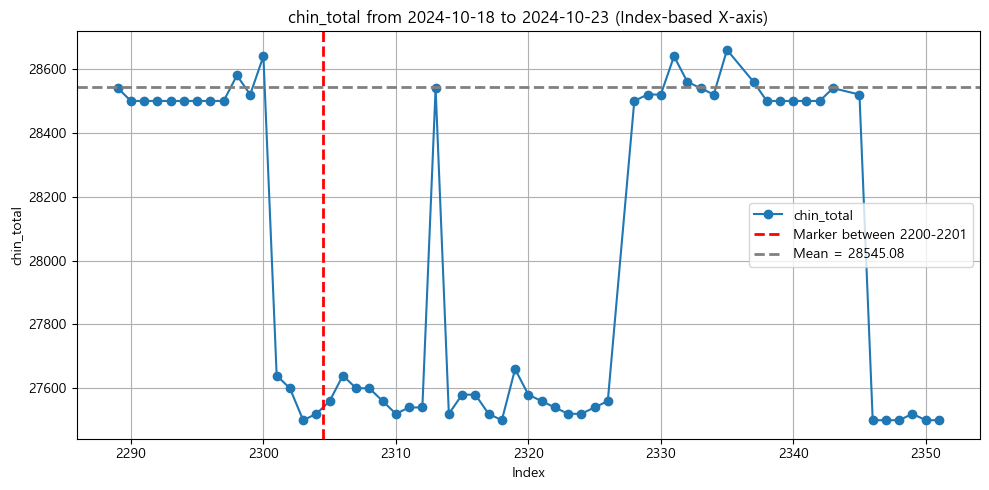

In [27]:
plot_column_by_date(df, 'chin_total', '2024-10-18', '2024-10-23', exclude= [], marker_between= (2200, 2201), mean_line=28545.08)